In [0]:
!pip install tensorflow-gpu==2

In [0]:
import time

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

### Input Pipeline

The Portuguese–English translation dataset from the TED Talks Open Translation Project.

In [0]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

In [85]:
# Example
for pt, en in train_examples.take(1):
    print("Datum 1 Portuguese:\n\t", pt)
    print("Datum 1 English:\n\t", en)

Datum 1 Portuguese:
	 tf.Tensor(b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .', shape=(), dtype=string)
Datum 1 English:
	 tf.Tensor(b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them .", shape=(), dtype=string)


Create the subwords tokenizers.

In [0]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    # corpus generator
    (en.numpy() for pt, en in train_examples),
    target_vocab_size=2**13
)

tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    # corpus generator
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size=2**13
)

In [86]:
print(tokenizer_en)
print(tokenizer_pt)

<SubwordTextEncoder vocab_size=8087>
<SubwordTextEncoder vocab_size=8214>


In [87]:
# Example
sample_string = "Transformer is awesome!"

tokenized_string = tokenizer_en.encode(sample_string)
recovered_string = tokenizer_en.decode(tokenized_string)
assert recovered_string == sample_string

print("Tokenized string:\n\t", tokenized_string)
print("Original string:\n\t", recovered_string)

Tokenized string:
	 [7915, 1248, 7946, 7194, 13, 2799, 7864]
Original string:
	 Transformer is awesome!


The tokenizer encodes a string by breaking it into subwords if the word is *not* in its dictionary.

In [8]:
for idx in tokenized_string:
    print("{} ----> {}".format(idx, tokenizer_en.decode([idx])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7864 ----> !


Add a start token and end token to the input and target.

In [0]:
def encode(pt_string, en_string):
    pt_idxs = ([tokenizer_pt.vocab_size]  # Start token
               + tokenizer_pt.encode(pt_string.numpy())  # Given tokens
               + [tokenizer_pt.vocab_size + 1]  # End token
    )
    en_idxs = ([tokenizer_en.vocab_size]
               + tokenizer_en.encode(en_string.numpy())
               + [tokenizer_en.vocab_size + 1]
    )
    return pt_idxs, en_idxs

To keep the example small, let's drop the examples with a length of over 40 tokens.

In [0]:
MAX_LENGTH = 40

def filter_max_length(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                          tf.size(y) <= max_length)

The tokenizers' `encode` method expects a `str` or `bytes`.
But the operations given to `Dataset.map` running in the graph mode receive a graph tensor that *do not have* `.numpy()` attribute.
So we need to run the encoding inside `tf.py_function`:

In [0]:
def tf_encode(pt_string, en_string):
    return tf.py_function(encode,  # Python object
                          [pt_string, en_string],  # Input tensors
                          [tf.int64, tf.int64]  # Output types
    )

And then we prepare batches.

In [0]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

train_dataset = train_examples.map(tf_encode).filter(filter_max_length)
# Cache the dataset to memory to get a speedup while reading.
train_dataset = train_dataset.cache()
# While batching, pad each of pt and en to their max lengths.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(
    BATCH_SIZE, padded_shapes=([-1], [-1]))
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = val_examples.map(tf_encode).filter(filter_max_length)
val_dataset = val_dataset.padded_batch(BATCH_SIZE,
                                       padded_shapes=([-1], [-1]))

In [94]:
# Example
pt_batch, en_batch = next(iter(val_dataset))
print(pt_batch)
print()
print(en_batch)

tf.Tensor(
[[8214 1259    5 ...    0    0    0]
 [8214  299   13 ...    0    0    0]
 [8214   59    8 ...    0    0    0]
 ...
 [8214   95    3 ...    0    0    0]
 [8214 5157    1 ...    0    0    0]
 [8214 4479 7990 ...    0    0    0]], shape=(64, 40), dtype=int64)

tf.Tensor(
[[8087   18   12 ...    0    0    0]
 [8087  634   30 ...    0    0    0]
 [8087   16   13 ...    0    0    0]
 ...
 [8087   12   20 ...    0    0    0]
 [8087   17 4981 ...    0    0    0]
 [8087   12 5453 ...    0    0    0]], shape=(64, 40), dtype=int64)


We can see the Portuguese strings and English strings have been padded to the lengths of 40 and 40, respectively.

### Positional encoding

$\quad \mathrm{PE}_{(\mathrm{pos}, 2i)} = \sin{\left( \frac{\mathrm{pos}}{10000^{2i/d_{\mathrm{model}}}} \right)} $

$\quad \mathrm{PE}_{(\mathrm{pos}, 2i+1)} = \cos{\left( \frac{\mathrm{pos}}{10000^{2i/d_{\mathrm{model}}}} \right)} $

In [0]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power( 10000, 2*(i//2)/np.float32(d_model) )
    return pos * angle_rates

def positional_encoding(max_position, d_model):
    angle_rads = get_angles(np.arange(max_position)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    
    # Apply sin to the even indices.
    angle_rads[:,::2] = np.sin(angle_rads[:,::2])
    # Apply cos to the odd indices.
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])
    # Unsqueeze
    pos_encoding = angle_rads[np.newaxis,...]

    return tf.cast(pos_encoding, dtype=tf.float32)

Positional encoding shape: (1, 50, 512)


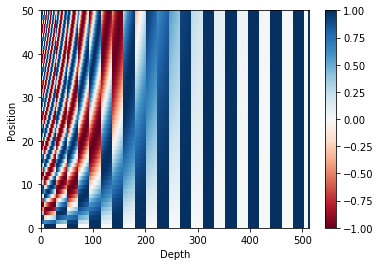

In [15]:
# Return shape
pos_encoding = positional_encoding(50, 512)
print("Positional encoding shape:", pos_encoding.shape)

# Depiction of the positional encoding
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Masking

First, the **padding mask** pads all the *padding tokens* in a batch of sequences, ensuring that the model does not treate paddings as input.

In [0]:
def create_padding_mask(seq):
    """\
    seq: (num_seq, seq_len)
    Return: (batch_size, 1, 1, seq_len)
    """
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # Extra dimensions to add the padding to the attention logits.
    # (batch_size, 1, 1, seq_len)
    mask = mask[:, tf.newaxis, tf.newaxis, :]
    return mask

In [17]:
# Example
x = tf.constant([[7, 6, 0, 0, 1], 
                 [1, 2, 3, 0, 0],
                 [0, 0, 0, 4, 5]])
print(create_padding_mask(x))

tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


We can see how the 0's are masked.

Second, the **look-ahead mask** masks the future tokens in a sequence. When predicting a word, the look-ahead mask makes the model use only the previously predicted words, excluding the current and future words.

In [0]:
def create_look_ahead_mask(size):
    """\
    Return: (size, size)
    """
    # ones - lower_triangle => upper_triangle_without_diagonal
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [19]:
# Example
x = tf.random.uniform((1, 3))
print(create_look_ahead_mask(x.shape[1]))

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


### Scaled dot-product attention

![대체 텍스트](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)

$\quad \mathrm{Attention} \left(Q,K,V\right) = \mathrm{softmax} \left(\frac{QK^\top}{\sqrt{d_k}}\right)V $

- $Q$: `(num_queries, d_k)`
- $K$: `(num_keys, d_k)`
- $V$: `(num_values, d_v)`

where `num_keys == num_values` (paired).

So the return shape is `(num_queries, d_v)`.

Note that in the actual code, the batch dimension is added to the front of the all shapes above.

In [0]:
def scaled_dot_product_attention(q, k, v, mask):
    """\
    The whole operation is done to the last two dimension,
    independently to the preceding dimensions.
    The preceding dimensions will be (batch_size, num_heads)
    in the multi-head attention.

    Arguments
    ---------
    q: (..., seq_len_q, d_k)
    k: (..., seq_len_k, d_k)
    v: (..., seq_len_v, d_v)
    mask: Float tensor with shape broadcastable to
          (..., seq_len_q, seq_len_k). Defaults to None.

    Returns
    -------
    output: (..., seq_len_q, d_v)
    attention_weights: (..., seq_len_q, seq_len_k)
    """
    qk = tf.matmul(q, k, transpose_b=True)
    # -> (..., seq_len_q, seq_len_k)

    # Scaling
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = qk / tf.math.sqrt(d_k)

    # Masking
    if mask is not None:
        # Set a large value to the masked elements
        # so that the softmax deactivates them.
        scaled_attention_logits += (mask * -1e9)
    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # -> (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)
    # -> (..., seq_len_q, d_v)

    return output, attention_weights

In [0]:
# Helper function
def print_out(q, k, v):
    temp_out, temp_attn = scaled_dot_product_attention(q, k, v, mask=None)
    print("Attention weigts:\n", temp_attn)
    print("Output:\n", temp_out)

To see how the attention works, let's first define an example of keys and values.

In [0]:
np.set_printoptions(suppress=True)

# (seq_len_k, depth_k) == (4, 3)
temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)

# (seq_len_v, depth_v) == (4, 2)
temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)

We give a query that aligns with the *second* key so that the *second* value is returned.

In [23]:
# (seq_len_q, depth_q==depth_k) == (1, 3)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)
# (seq_len_q, depth_v)
print_out(temp_q, temp_k, temp_v)

Attention weigts:
 tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output:
 tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


See how the second attention weight only gets a value.

Now we give another query that aligns with a *repeated* key (the thirg and fourth key of `temp_k`) so that all the associated values get averaged.

In [24]:
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k ,temp_v)

Attention weigts:
 tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output:
 tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


See the `0.5` in the third and fourth weights.

We give yet another query that aligns equally with the first and second keys so that their values get averaged.

In [25]:
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weigts:
 tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output:
 tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


And then let's give the queries together.

In [27]:
temp_q = tf.constant([[0, 10, 0],
                      [0, 0, 10],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weigts:
 tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output:
 tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


We can see how the previous weights and outputs are collected.

### Multi-head attention

![대체 텍스트](https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png)

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert d_model % num_heads == 0

        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result into (batch_size, num_heads, seq_len, depth).
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        """\
        Returns
        -------
        output: (batch_size, seq_len_q, d_model)
        attention_weights: (batch_size, num_heads, seq_len_q, seq_len_k)
        """
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape -> (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape -> (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask
        )

        # Transpose: (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # Concat: (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)

        return output, attention_weights

Try out the layer to a 60-length 512-depth sequence (*i.e.*, self-attention).

In [32]:
# Example
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
# (batch_size, encoder_sequence, d_model)
y = tf.random.uniform((1, 60, 512))
# Self-attention
out, attn = temp_mha(y, k=y, q=y, mask=None)
print(out.shape, attn.shape)

(1, 60, 512) (1, 8, 60, 60)


### Point-wise feed forward network

In [0]:
def point_wise_feed_forward_network(d_model, d_ff):
    layers = tf.keras.Sequential([
        tf.keras.layers.Dense(d_ff, activation='relu'),
        # -> (batch_size, seq_len, d_ff)
        tf.keras.layers.Dense(d_model)
        # -> (batch_size, seq_len, d_model)   
    ])
    return layers

In [36]:
# Example
sample_ffn = point_wise_feed_forward_network(512, 2048)
print(
    sample_ffn(tf.random.uniform((64, 50, 512))).shape
)

(64, 50, 512)


### Encoder and decoder

![대체 텍스트](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

#### Encoder layer

1. Multi-head attention (with padding mask)
2. Point-wise feed forward network

In [0]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, p_drop=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        # epsilon: a small value added to variance to avoid zero division.
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(p_drop)
        self.dropout2 = tf.keras.layers.Dropout(p_drop)

    def call(self, x, training, mask):
        ## First sublayer: self-attention
        attn_output, _ = self.mha(x, x, x, mask)
        # -> (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        # Skip connection and layer normalization
        out1 = self.layernorm1(x + attn_output)
        # -> (batch_size, input_seq_len, d_model)

        ## Second sublayer: point-wise FFN
        ffn_output = self.ffn(out1)
        # -> (batch_size, intput_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        # -> (batch_size, intput_seq_len, d_model)

        return out2

In [39]:
# Example
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)),
    training=False,
    mask=None
)
print(sample_encoder_layer_output.shape)
print("# (batch_size, intput_seq_len, d_model)")

(64, 43, 512)
# (batch_size, intput_seq_len, d_model)


#### Decoder layer

1. Multi-head attention (with look-ahead mask and padding mask)
2. Multi-head attention (with padding mask)
3. Point-wise feed forward network

In step 2, $V$ and $K$ receive the *encoder output* as inputs, and $Q$ receives the output of step 1, *i.e.*, the first attention block.

In [0]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, p_drop=0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, d_ff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(p_drop)
        self.dropout2 = tf.keras.layers.Dropout(p_drop)
        self.dropout3 = tf.keras.layers.Dropout(p_drop)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        """\
        enc_output: (batch_size, input_seq_len, d_model)
        """
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        # -> (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        )  # -> (batch_size, target_seq_len, d_model)
        out2 = self.layernorm2(out1 + attn2)
        # -> (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)
        # -> (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        # -> (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [47]:
# Example
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    training=False, look_ahead_mask=None, padding_mask=None
)
print(sample_decoder_layer_output.shape)
print("# (batch_size, target_seq_len, d_model)")

(64, 50, 512)
# (batch_size, target_seq_len, d_model)


#### Encoder

1. Input embedding
2. Positional encoding
3. $N$ encoder layers

In [0]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                 input_vocab_size, maximum_position_encoding, p_drop=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, d_ff, p_drop)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(p_drop) 

    def call(self, x, training, mask):
        """\
        Return: (batch_size, input_seq_len, d_model)
        """
        seq_len = tf.shape(x)[1]

        # Embedding and positional encoding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # Scaling after embedding [Vaswani 2017 p.5]
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        
        return x

In [53]:
# Example
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 64), dtype=tf.int64, minval=0, maxval=200)
sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_layer_output.shape)
print("# (batch_size, input_seq_len, d_model)")

(64, 43, 512)
# (batch_size, input_seq_len, d_model)


#### Decoder

1. Output embedding
2. Positional encoding
3. $N$ decoder layers

In [0]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                 target_vocab_size, maximum_position_encoding, p_drop=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, d_ff, p_drop)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(p_drop)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        """\
        Return: (batch_size, target_seq_len, d_model)
        """
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask,
                                                   padding_mask)
            
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2
        
        return x, attention_weights

In [57]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         d_ff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)
output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

print("Output shape:", output.shape)
print("Attention matrix shape:", attn['decoder_layer2_block2'].shape)
print("# (batch_size, num_heads, input_seq_len, d_v)")

Output shape: (64, 26, 512)
Attention matrix shape: (64, 8, 26, 64)
# (batch_size, num_heads, input_seq_len, d_v)


### The Transformer

In [0]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, d_ff,
                 input_vocab_size, target_vocab_size,
                 pe_input, pe_target, p_drop=0.1):
        super().__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff,
                               input_vocab_size, pe_input, p_drop)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff,
                               target_vocab_size, pe_target, p_drop)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, target, training, enc_padding_mask,
             look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        # -> (batch_size, inp_seq_len, d_model)

        # dec_output.shape -> (batch_size, target_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            target, enc_output, training, look_ahead_mask, dec_padding_mask
        )

        final_output = self.final_layer(dec_output)
        # -> (batch_size, target_seq_len, target_vocab_size)

        return final_output, attention_weights

In [64]:
# Example
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, d_ff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000
)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target,
                               training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print(fn_out.shape)
print("# (batch_size, target_seq_len, target_vocab_size)")

(64, 36, 8000)
# (batch_size, target_seq_len, target_vocab_size)


### Hyperparameters

In [0]:
num_layers = 4
d_model = 128
d_ff = 512
num_heads = 8

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

### Optimizer

Following the paper, we use the following learning-rate scheduling:

$\quad l_\mathrm{rate} = d^{-0.5}_\mathrm{model} * \min{\left( \text{step_num}^{-0.5}, \text{step_num} * \text{warmup_steps}^{-1.5} \right)}$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        l_rate = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return l_rate

In [0]:
scheduler = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(scheduler,
                                     beta_1=0.9,
                                     beta_2=0.98,
                                     epsilon=1e-9)

Depiction of the learning-rate schedule

Text(0, 0.5, 'Learning rate')

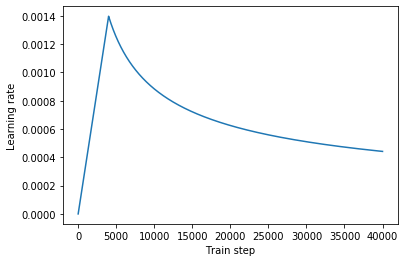

In [70]:
temp_schedule = CustomSchedule(d_model)

plt.plot(temp_schedule(tf.range(40000, dtype=tf.float32)))
plt.xlabel("Train step")
plt.ylabel("Learning rate")

### Loss and metrics

In [0]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    losses = loss_object(real, pred)

    mask = tf.cast(mask, dtype=losses.dtype)
    losses *= mask
    loss = tf.reduce_mean(losses)
    
    return loss

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name="train_accuracy"
)

### Training and checkpoint

In [0]:
transformer = Transformer(num_layers, d_model, num_heads, d_ff,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          p_drop=dropout_rate)

In [0]:
def create_masks(inp, target):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # For the 2nd attention block in the decoder.
    # This masks the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # For the 1st attention block in the decoder.
    # This pads and masks future tokens in the input received by the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(target)[1])
    dec_target_padding_mask = create_padding_mask(target)
    combined_mask = tf.maximum(look_ahead_mask, dec_target_padding_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [0]:
checkpoint_dir = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=5)

# If a checkpoint already exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print("Latest checkpoint restored!")

For each target sequence, prepare a `target_input` and `target_real` such that (see how the two are differently shifted):

`target` -> "SOS A lion in the jungle is sleeping EOS"

`target_input` -> "SOS A lion in the jungle is sleeping"

`target_real` -> "A lion in the jungle is sleeping EOS"

For faster execution, we trace-compile `train_step` (defined below) into a TF graph.
`tf.function` specializes to fixed shapes of argument tensors.
Hence, to avoid re-tracing due to variable sequence lengths or batch sizes, we use `input_signature` to specify more generic shapes.

In [0]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=train_step_signature)
def train_step(inp, target):
    target_input = target[:, :-1]
    target_real = target[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, target_input)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, target_input,
                                     training=True,
                                     enc_padding_mask=enc_padding_mask,
                                     look_ahead_mask=combined_mask,
                                     dec_padding_mask=dec_padding_mask)
        loss = loss_function(target_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(target_real, predictions)

In out task, Portuguese is the input language and English is the target language.

In [102]:
EPOCHS = 20

for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
    train_accuracy.reset_states()

    for batch, (inp, target) in enumerate(train_dataset):
        train_step(inp, target)

        if batch % 50 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4}".format(
                epoch + 1, batch, train_loss.result(), train_accuracy.result()
            ))
    if (epoch+1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f"Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}")
    
    print("Epoch {} Loss {:.4f} Accuracy {:.4f}".format(epoch + 1,
                                                        train_loss.result(),
                                                        train_accuracy.result()))
    print("Time taken for the epoch: {} secs\n".format(time.time() - start))

Epoch 1 Batch 0 Loss 3.9876 Accuracy 0.0
Epoch 1 Batch 50 Loss 4.2411 Accuracy 0.0001979
Epoch 1 Batch 100 Loss 4.2063 Accuracy 0.01194
Epoch 1 Batch 150 Loss 4.1429 Accuracy 0.01707
Epoch 1 Batch 200 Loss 4.0856 Accuracy 0.02044
Epoch 1 Batch 250 Loss 4.0158 Accuracy 0.02388
Epoch 1 Batch 300 Loss 3.9132 Accuracy 0.02924
Epoch 1 Batch 350 Loss 3.8157 Accuracy 0.03364
Epoch 1 Batch 400 Loss 3.7366 Accuracy 0.03719
Epoch 1 Batch 450 Loss 3.6551 Accuracy 0.03992
Epoch 1 Batch 500 Loss 3.5844 Accuracy 0.04239
Epoch 1 Batch 550 Loss 3.5267 Accuracy 0.04566
Epoch 1 Batch 600 Loss 3.4678 Accuracy 0.04903
Epoch 1 Batch 650 Loss 3.4109 Accuracy 0.05228
Epoch 1 Batch 700 Loss 3.3596 Accuracy 0.05559
Epoch 1 Loss 3.3575 Accuracy 0.0557
Time taken for the epoch: 86.10137104988098 secs

Epoch 2 Batch 0 Loss 2.4412 Accuracy 0.1013
Epoch 2 Batch 50 Loss 2.5791 Accuracy 0.1038
Epoch 2 Batch 100 Loss 2.5419 Accuracy 0.107
Epoch 2 Batch 150 Loss 2.5128 Accuracy 0.1095
Epoch 2 Batch 200 Loss 2.4910 Accu

### Evaluation

1. Encode the input sequence using `tokenizer_pt` with the start token and end token.
2. The decoder input, *i.e.*, the start token is `tokenizer_en.vocab_size`.
3. Create the padding masks and look-ahead masks.
4. The decoder outputs the predictions by looking at the encoder output and its own output (self-attention).
5. Select the last word and take `argmax`. (As more words are predicted, the number of predicted words also increases, while we only need the latest predicted word.)
6. Concatenate the predicted word to the decoder input and pass it to the decoder.
7. The decoder predicts the next word based on the previously predicted words.

In [0]:
def evaluate(input_sentence):
    # Tokenize the input sentence and add the start and end tokens.
    start_token = [tokenizer_pt.vocab_size]
    end_token = [tokenizer_pt.vocab_size + 1]
    input_sentence = start_token + tokenizer_pt.encode(input_sentence) + end_token
    encoder_input = tf.expand_dims(input_sentence, 0)

    # Decoder start token
    decoder_input = [tokenizer_en.vocab_size]
    output = tf.expand_dims(decoder_input, 0)

    for i in range(MAX_LENGTH):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output
        )

        # predictions.shape -> (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # Select the last word (while preserving the axis).
        # (Following `i`, `seq_len` increases as `i+1`.)
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_idx = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Terminate if the end token is predicted.
        if predicted_idx == tokenizer_en.vocab_size + 1:
            return tf.squeeze(output, axis=0), attention_weights
        
        # Concatenate the predicted index.
        output = tf.concat([output, predicted_idx], axis=-1)
    
    return tf.squeeze(output, axis=0), attention_weights

In [0]:
def plot_attention_weights(attention, sentence, result, layer):
    """\
    Arguments
    ---------
    attention: attention_weights dict
    sentence: input str
    result: predicted indices
    layer: layer name to see the attention weights
    """
    fig = plt.figure(figsize=(16, 8))
    sentence = tokenizer_pt.encode(sentence)
    attention = tf.squeeze(attention[layer], axis=0)  # Unsqueeze the batch axis.

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head + 1)
        ax.matshow(attention[head][:-1, :], cmap='viridis')
        
        ax.set_xticks(range(len(sentence)+2))
        ax.set_yticks(range(len(result)))
        ax.set_ylim(len(result)-1.5, -0.5)

        fontdict = {'fontsize': 10}
        ax.set_xticklabels(
            ['<start>'] + [tokenizer_pt.decode([i]) for i in sentence] + ['<end>'],
            fontdict=fontdict,
            rotation=90
        )
        ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                            if i < tokenizer_en.vocab_size],
                           fontdict=fontdict)
        ax.set_xlabel(f'Head {head+1}')
    
    plt.tight_layout()
    plt.show()

In [0]:
def translate(sentence, plot_layer=''):
    result, attention_weights = evaluate(sentence)

    predicted_sentence = tokenizer_en.decode([i for i in result
                                              if i < tokenizer_en.vocab_size])
    
    print("Input:\n\t", sentence)
    print("Translation:\n\t", predicted_sentence)

    if plot_layer:
        plot_attention_weights(attention_weights, sentence, result, plot_layer)

#### Examples

Note that the model capacity here has been reduced for fast practice so the prediction may be unsatisfactory.

In [112]:
translate("este é um problema que temos que resolver.")
print("Real translation:\n\t",
      "this is a problem we have to solve .")

Input:
	 este é um problema que temos que resolver.
Translation:
	 this is one problem we need to deal with it .
Real translation:
	 this is a problem we have to solve .


In [113]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print("Real translation:\n\t",
      "and my neighboring homes heard about this idea .")

Input:
	 os meus vizinhos ouviram sobre esta ideia.
Translation:
	 my neighbors heard about this idea .
Real translation:
	 and my neighboring homes heard about this idea .


In [114]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print("Real translation:\n\t",
      "so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input:
	 vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Translation:
	 so i 'm going to quickly to share with you some of some magic stories that have happened .
Real translation:
	 so i 'll just share with you some stories very quickly of some magical things that have happened .


We can also see the attention weights within a block in a desired layer.

Input:
	 este é o primeiro livro que eu fiz.
Translation:
	 this is the first book i did .


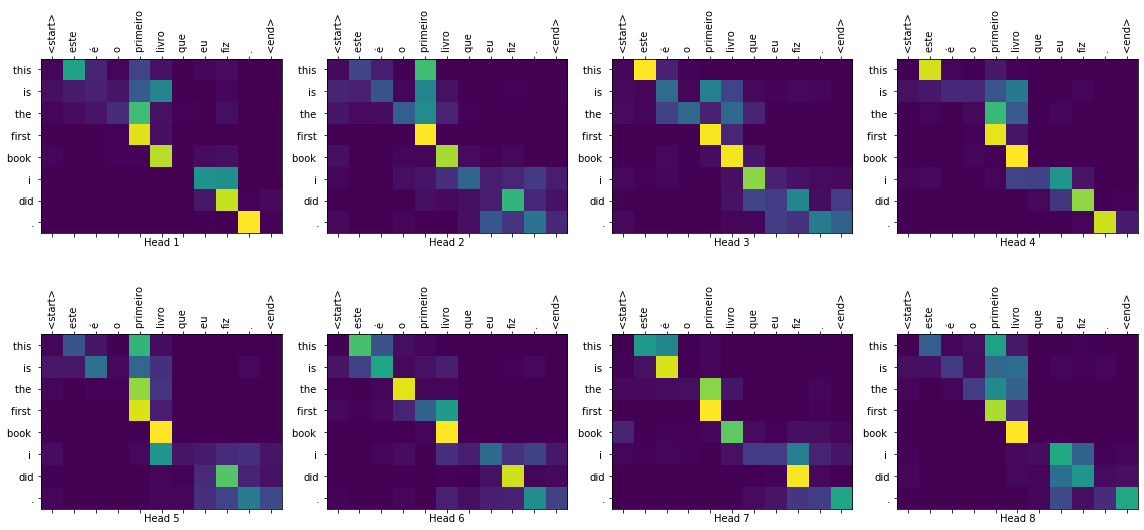

Real translation:
	 this is the first book i've ever done.


In [117]:
translate("este é o primeiro livro que eu fiz.",
          plot_layer='decoder_layer4_block2')
print("Real translation:\n\t",
      "this is the first book i've ever done.")